Pretrained model을 활용해 Pretrained Model을 활용하여 한국형 SQuAD인 KorQuAD 태스크를 수행하는 모델을 학습해 보겠습니다.

## 0. Module import 및 KorQuAD 데이터 로드

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_addons as tfa

import os
import re
import numpy as np
import pandas as pd
import pickle
import random
import collections
import json
from datetime import datetime

import sentencepiece as spm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

random_seed = 321
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

다운로드받은 KorQuAD 데이터를 확인해 봅시다. 아래 **print_json_tree()** 메소드는 KorQuAD 데이터처럼 json 포맷으로 이루어진 데이터에서 리스트의 첫번째 아이템의 실제 내용을 간단히 확인할 수 있습니다.

In [2]:
def print_json_tree(data, indent=""):
    for key, value in data.items():
        if type(value) == list:     # list 형태의 item은 첫번째 item만 출력
            print(f'{indent}- {key}: [{len(value)}]')
            print_json_tree(value[0], indent + "  ")
        else:
            print(f'{indent}- {key}: {value}')

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/bert_qna/data'
model_dir = os.getenv('HOME')+'/aiffel/bert_qna/models'

# 훈련데이터 확인
train_json_path = data_dir + '/KorQuAD_v1.0_train.json'
with open(train_json_path) as f:
    train_json = json.load(f)
    print_json_tree(train_json)

- version: KorQuAD_v1.0_train
- data: [1420]
  - paragraphs: [3]
    - qas: [8]
      - answers: [1]
        - text: 교향곡
        - answer_start: 54
      - id: 6566495-0-0
      - question: 바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?
    - context: 1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.
  - title: 파우스트_서곡


In [4]:
# 검증데이터 확인
dev_json_path = data_dir + '/KorQuAD_v1.0_dev.json'
with open(dev_json_path) as f:
    dev_json = json.load(f)
    print_json_tree(dev_json)

- version: KorQuAD_v1.0_dev
- data: [140]
  - paragraphs: [2]
    - qas: [7]
      - answers: [1]
        - text: 1989년 2월 15일
        - answer_start: 0
      - id: 6548850-0-0
      - question: 임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
    - context: 1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
  - title: 임종석


json 데이터의 실제 형태는 아래와 같이 **json.dumps()**를 이용해 확인해 볼 수 있습니다.

In [5]:
# 아래 코드를 실행하면 json 데이터를 확인할 수 있습니다.
print(json.dumps(train_json["data"][0], indent=2, ensure_ascii=False))

--- 

## 1. KorQuAD 데이터셋 전처리
- 띄어쓰기 단위 , Subword Segmentation, Improve Span, 데이터셋 분리의 과정을 거쳐서 데이터셋 전처리를 진행하겠습니다. 


### 1-1. 띄어쓰기 단위 정보관리
띄어쓰기 단위로는 공백의 개수에 따라 다르게 처리되어야 하는데 아래의 예시와 같이 설명하겠습니다.

In [6]:
def _is_whitespace(c):
    if c == " " or c == "\t" or c == "\r" or c == "\n" or ord(c) == 0x202F:
        return True
    return False

In [7]:
# whitespace가 2개인 경우를 처리해야 함

string1 = '13세기 단테의신곡을 읽었다'
string2 = '13세기  단테의신곡을 읽었다'
string1[5:10], string2[6:11]

('단테의신곡', '단테의신곡')

In [8]:
word_tokens = []
char_to_word = []
prev_is_whitespace = True

# 첫번째 문장(string1)에 대해 띄어쓰기 영역 정보를 표시
for c in string1:
    if _is_whitespace(c):
        prev_is_whitespace = True
    else:
        if prev_is_whitespace:
            word_tokens.append(c)
        else:
            word_tokens[-1] += c
        prev_is_whitespace = False    
    char_to_word.append(len(word_tokens) - 1)
    print(f'\'{c}\' : {word_tokens} : {char_to_word}')
print('String_1 :',len(char_to_word))

'1' : ['1'] : [0]
'3' : ['13'] : [0, 0]
'세' : ['13세'] : [0, 0, 0]
'기' : ['13세기'] : [0, 0, 0, 0]
' ' : ['13세기'] : [0, 0, 0, 0, 0]
'단' : ['13세기', '단'] : [0, 0, 0, 0, 0, 1]
'테' : ['13세기', '단테'] : [0, 0, 0, 0, 0, 1, 1]
'의' : ['13세기', '단테의'] : [0, 0, 0, 0, 0, 1, 1, 1]
'신' : ['13세기', '단테의신'] : [0, 0, 0, 0, 0, 1, 1, 1, 1]
'곡' : ['13세기', '단테의신곡'] : [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
'을' : ['13세기', '단테의신곡을'] : [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
' ' : ['13세기', '단테의신곡을'] : [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
'읽' : ['13세기', '단테의신곡을', '읽'] : [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2]
'었' : ['13세기', '단테의신곡을', '읽었'] : [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2]
'다' : ['13세기', '단테의신곡을', '읽었다'] : [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2]
String_1 : 15


In [9]:
word_tokens = []
char_to_word = []
prev_is_whitespace = True

# 두번째 문장(string2)에 대해 띄어쓰기 영역 정보를 표시
for c in string2:
    if _is_whitespace(c):
        prev_is_whitespace = True
    else:
        if prev_is_whitespace:
            word_tokens.append(c)
        else:
            word_tokens[-1] += c
        prev_is_whitespace = False    
    char_to_word.append(len(word_tokens) - 1)
    print(f'\'{c}\' : {word_tokens} : {char_to_word}')
print('String_2 :',len(char_to_word))

'1' : ['1'] : [0]
'3' : ['13'] : [0, 0]
'세' : ['13세'] : [0, 0, 0]
'기' : ['13세기'] : [0, 0, 0, 0]
' ' : ['13세기'] : [0, 0, 0, 0, 0]
' ' : ['13세기'] : [0, 0, 0, 0, 0, 0]
'단' : ['13세기', '단'] : [0, 0, 0, 0, 0, 0, 1]
'테' : ['13세기', '단테'] : [0, 0, 0, 0, 0, 0, 1, 1]
'의' : ['13세기', '단테의'] : [0, 0, 0, 0, 0, 0, 1, 1, 1]
'신' : ['13세기', '단테의신'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
'곡' : ['13세기', '단테의신곡'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
'을' : ['13세기', '단테의신곡을'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
' ' : ['13세기', '단테의신곡을'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
'읽' : ['13세기', '단테의신곡을', '읽'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2]
'었' : ['13세기', '단테의신곡을', '읽었'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2]
'다' : ['13세기', '단테의신곡을', '읽었다'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2]
String_2 : 16


위의 2 문자열의 대한 영역 표시를 살펴보면 두 문장의 영역표시가 조금 달라 졌고 그에 따라 문자열의 길이도 더 길어졌네요.  

위의 기능을 함수로 만들겠습니다.

In [10]:
def _tokenize_whitespace(string):
    word_tokens = []
    char_to_word = []
    prev_is_whitespace = True

    for c in string:
        if _is_whitespace(c):
            prev_is_whitespace = True
        else:
            if prev_is_whitespace:
                word_tokens.append(c)
            else:
                word_tokens[-1] += c
            prev_is_whitespace = False    
        char_to_word.append(len(word_tokens) - 1)
    
    return word_tokens, char_to_word

위와 같은 방법으로 띄어쓰기 단위로 token을 정리한 후, word token 영역별로 유니크한 숫자(어절 번호)를 부여합니다. SQuAD 유형의 문제를 풀 때 글자 혹은 subword 단위로 token이 분리되는 것에 대비해서 **원래 데이터가 띄어쓰기 단위로 어떠했었는지 word token 영역별로 추가 정보를 관리**하면 도움이 됩니다. 아래와 같이 글자별로 word_token 영역을 표시해 주는 **char_to_word** list를 관리해 둡니다. 이 값은 현재 글자가 몇 번째 어절에 포함된 것이었는지를 말해 줍니다.

위 두 문장에 대해 방금 만든 함수를 다시 적용해 보았습니다.

In [11]:
# 첫번째 문장(string1)에 대해 띄어쓰기 영역 정보를 표시
word_tokens, char_to_word = _tokenize_whitespace(string1)
for c, i in zip(list(string1), char_to_word):
    print(f'\'{c}\' : {i}')

word_tokens, char_to_word

'1' : 0
'3' : 0
'세' : 0
'기' : 0
' ' : 0
'단' : 1
'테' : 1
'의' : 1
'신' : 1
'곡' : 1
'을' : 1
' ' : 1
'읽' : 2
'었' : 2
'다' : 2


(['13세기', '단테의신곡을', '읽었다'], [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2])

In [12]:
# 두번째 문장(string2)에 대해 띄어쓰기 영역 정보를 표시
word_tokens, char_to_word = _tokenize_whitespace(string2)
for c, i in zip(list(string2), char_to_word):
    print(f'\'{c}\' : {i}')

word_tokens, char_to_word

'1' : 0
'3' : 0
'세' : 0
'기' : 0
' ' : 0
' ' : 0
'단' : 1
'테' : 1
'의' : 1
'신' : 1
'곡' : 1
'을' : 1
' ' : 1
'읽' : 2
'었' : 2
'다' : 2


(['13세기', '단테의신곡을', '읽었다'], [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2])

### 1-2. Subword Segmentation  [Tokenize by Vocab]
---
>읽다, 읽었다, 읽어라, 읽고, 읽으려면, 읽다가….

위와 같이 모든 단어를 전부 단어사전에 추가한다면 너무 많은 단어가 필요할 것입니다.  Word 기반의 단어사전 구축이 가지는 문제점 입니다.  특히 한국어의 경우 `노란, 노랑, 노랗다, 누리끼리한, 누르스름한, 누런...` 등 비슷한 의미를 가진 많은 단어가 존재하죠.  

이러한 문제점을 해결하기 위해 '읽었다'를 '읽'+ '었다'와 같이 나누어서 처리하면 해결되지 않을까하는 생각에서 나온 접근법을 **'Subword Segmentation'**이라고 합니다.

한국어의 경우에는 **koNLPy**를 통해 사용할 수 있는 형태소분석기가 이런 역할을 합니다. 하지만 SentencePiece 같은 모델들은 언어마다 다른 문법규칙을 활용하지 않고, 적절한 Subword 분절 규칙을 학습하거나, 혹은 자주 사용되는 구문을 하나의 단어로 묶어내는 등 통계적인 방법을 사용합니다. 

In [13]:
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(f"{model_dir}/ko_32000.model")

# word를 subword로 변경하면서 index 저장
word_to_token = []
context_tokens = []
for (i, word) in enumerate(word_tokens):
    word_to_token.append(len(context_tokens))
    tokens = vocab.encode_as_pieces(word)  # SentencePiece를 사용해 Subword로 쪼갭니다.
    for token in tokens:
        context_tokens.append(token)

context_tokens, word_to_token

(['▁13', '세기', '▁단', '테', '의', '신', '곡을', '▁읽', '었다'], [0, 2, 7])

위에 '\_읽'에는 '\_'이 있고, '었다'에는 '\_'가 없습니다.   
'\_' 표시는 앞부분이 공백이라는 뜻입니다.

SentencePiece를 활용하는 위 코드도 아래와 같이 함수로 만들어 두겠습니다.

In [14]:
def _tokenize_vocab(vocab, context_words):
    word_to_token = []
    context_tokens = []
    for (i, word) in enumerate(context_words):
        word_to_token.append(len(context_tokens))
        tokens = vocab.encode_as_pieces(word)
        for token in tokens:
            context_tokens.append(token)
    return context_tokens, word_to_token

In [15]:
print(word_tokens)  # 처리해야 할 word 단위 입력

context_tokens, word_to_token = _tokenize_vocab(vocab, word_tokens)
context_tokens, word_to_token   # Subword 단위로 토큰화한 결과

['13세기', '단테의신곡을', '읽었다']


(['▁13', '세기', '▁단', '테', '의', '신', '곡을', '▁읽', '었다'], [0, 2, 7])

### 1-3. Improve Span
---

KorQuAD 데이터셋에서 context, question, answer를 뽑아 봅니다. KorQuAD 데이터셋은 **질문(question)**과 **지문(context)**을 주고, **지문** 영역에서 **정답(answer)**을 찾도록 구성되어 있습니다. 그러므로 **정답**에 해당하는 **지문** 영역을 정확히 찾아내는 것이 전처리의 핵심적인 작업이 됩니다.

In [16]:
context = train_json['data'][5]['paragraphs'][0]['context']
question = train_json['data'][5]['paragraphs'][0]['qas'][0]['question']
answer_text = train_json['data'][5]['paragraphs'][0]['qas'][0]['answers'][0]['text']
answer_start = train_json['data'][5]['paragraphs'][0]['qas'][0]['answers'][0]['answer_start']
answer_end = answer_start + len(answer_text) - 1

print('[context] ', context)
print('[question] ', question)
print('[answer] ', answer_text)
print('[answer_start] index: ', answer_start, 'character: ', context[answer_start])
print('[answer_end]index: ', answer_end, 'character: ', context[answer_end])

# answer_text에 해당하는 context 영역을 정확히 찾아내야 합니다. 
assert context[answer_start:answer_end + 1] == answer_text

[context]  초우라늄 원소의 존재는 1934년, 엔리코 페르미가 그의 연구를 바탕으로 제안한 것이다. 그러나, 그 당시 악티늄족은 4개의 원소밖에 존재하지 않아, 란타넘족과 비슷해진다는 개념을 사람들은 이해하지 못했다. 그 당시에 우세했던 주장은 초우라늄은 악티늄족이 아닌, 7주기에 들어가야 한다고 했던 것이다. 토륨과 프로탁티늄, 우라늄이 각각 6주기인 하프늄, 탄탈럼 그리고 텅스텐 아래에 있어야 한다는 것이었다. 초우라늄의 합성은 서서히 악티늄족의 중심을 파헤쳐갔다. 1944년에 악티늄족 가설을 완성시키기 위해 글렌 T. 시보그가 담당한 퀴륨의 산화 4 이상의 산화 상태 실험 실패를 관찰하였다. (6주기인 백금 아래에 있을 것으로 추정되었던 것인데, 백금은 산화 6까지 가능했기 때문이다.) 알려진 악티늄족의 가르침과 더 많은 초우라늄 원소들의 합성이 만들어낸 자료가 중심을 더 파고들어갔지만, 이 문장 "악티늄족 가설"("가설"의 영향은 결정적으로 입증되지 못했다.)은 남아서 1950년대 후반에 과학자들에 의해 적극적으로 활용하게 된다.
[question]  초우라늄 원소가 존재할 가능성을 처음 제안한 사람은?
[answer]  엔리코 페르미
[answer_start] index:  20 character:  엔
[answer_end]index:  26 character:  미


In [17]:
# context를 띄어쓰기(word) 단위로 토큰화한 결과를 살펴봅니다. 
word_tokens, char_to_word = _tokenize_whitespace(context)

print( word_tokens[:20])

char_to_word[:20], context[:20]

['초우라늄', '원소의', '존재는', '1934년,', '엔리코', '페르미가', '그의', '연구를', '바탕으로', '제안한', '것이다.', '그러나,', '그', '당시', '악티늄족은', '4개의', '원소밖에', '존재하지', '않아,', '란타넘족과']


([0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3],
 '초우라늄 원소의 존재는 1934년, ')

In [18]:
# 띄어쓰기(word) 단위로 쪼개진 context(word_tokens)를 Subword로 토큰화한 결과를 살펴봅니다. 
context_tokens, word_to_token = _tokenize_vocab(vocab, word_tokens)
for i in range(min(20, len(word_to_token) - 1)):
    print(word_to_token[i], context_tokens[word_to_token[i]:word_to_token[i + 1]])

0 ['▁초', '우라', '늄']
3 ['▁원소의']
4 ['▁존재', '는']
6 ['▁1934', '년', ',']
9 ['▁엔', '리코']
11 ['▁페르미', '가']
13 ['▁그의']
14 ['▁연구를']
15 ['▁바탕으로']
16 ['▁제안한']
17 ['▁것이다', '.']
19 ['▁그러나', ',']
21 ['▁그']
22 ['▁당시']
23 ['▁악', '티', '늄', '족은']
27 ['▁4', '개의']
29 ['▁원소', '밖에']
31 ['▁존재하지']
32 ['▁않아', ',']
34 ['▁란', '타', '넘', '족과']


이제 질문의 답을 떠올려 봅시다.

위에서 우리는 context에 포함된 answer의 글자단위 시작 인덱스 **answer_start**와 종료 인덱스 **answer_end**를 구했습니다. 이 위치를 어절(word) 단위로 변환해 보겠습니다.

In [19]:
# answer_start와 answer_end로부터 word_start와 word_end를 구합니다. 
word_start = char_to_word[answer_start]
word_end = char_to_word[answer_end]
word_start, word_end, answer_text, word_tokens[word_start:word_end + 1]

(4, 5, '엔리코 페르미', ['엔리코', '페르미가'])

우리가 찾는 정답은 5번째, 6번째 어절(index=4, 5)에 있었군요. 하지만 우리가 원하는 정답은 '엔리코 페르미'이지, '엔리코 페르미가'는 아닙니다.

그래서 이번에는 **word_start**로부터 **word_end**까지의 context를 Subword 단위로 토큰화한 결과를 살펴봅시다.


In [20]:
token_start = word_to_token[word_start]
if word_end < len(word_to_token) - 1:
    token_end = word_to_token[word_end + 1] - 1
else:
    token_end = len(context_tokens) - 1
token_start, token_end, context_tokens[token_start:token_end + 1]

(9, 12, ['▁엔', '리코', '▁페르미', '가'])

이제 거의 정답에 근접했습니다. Subword 단위로 토큰화한 결과 중에는 우리가 찾는 정답과 정확히 일치하는 답이 있는것 같습니다.

In [21]:
# 실제 정답인 answer_text도 Subword 기준으로 토큰화해 둡니다. 
token_answer = " ".join(vocab.encode_as_pieces(answer_text))
token_answer

'▁엔 리코 ▁페르미'

이제 눈으로 봐도 어디가 정확히 정답인지 알 수 있게 되었지만, 좀더 일반적인 방법으로 정답 토큰 범위를 찾는 코드를 작성해 보겠습니다. KorQuAD 문제의 정답은 이번처럼 단답형만 있는 것은 아니기 때문입니다.

In [22]:
# 정답이 될수 있는 new_start와 new_end의 경우를 순회탐색합니다. 
for new_start in range(token_start, token_end + 1):
    for new_end in range(token_end, new_start - 1, -1):
        text_span = " ".join(context_tokens[new_start : (new_end + 1)])
        if text_span == token_answer:   # 정답과 일치하는 경우
            print("O >>", (new_start, new_end), text_span)
        else:
            print("X >>", (new_start, new_end), text_span)

X >> (9, 12) ▁엔 리코 ▁페르미 가
O >> (9, 11) ▁엔 리코 ▁페르미
X >> (9, 10) ▁엔 리코
X >> (9, 9) ▁엔
X >> (10, 12) 리코 ▁페르미 가
X >> (10, 11) 리코 ▁페르미
X >> (10, 10) 리코
X >> (11, 12) ▁페르미 가
X >> (11, 11) ▁페르미
X >> (12, 12) 가


이제 context에서 answer의 위치를 토큰화된 상태에서 찾는 함수를 아래와 같이 정리할 수 있게 되었습니다.

In [23]:
# context_tokens에서 char_answer의 위치를 찾아 리턴하는 함수
def _improve_span(vocab, context_tokens, token_start, token_end, char_answer):
    token_answer = " ".join(vocab.encode_as_pieces(char_answer))
    for new_start in range(token_start, token_end + 1):
        for new_end in range(token_end, new_start - 1, -1):
            text_span = " ".join(context_tokens[new_start : (new_end + 1)])
            if text_span == token_answer:
                return (new_start, new_end)
    return (token_start, token_end)

In [24]:
token_start, token_end = _improve_span(vocab, context_tokens, token_start, token_end, answer_text)
print('token_start:', token_start, ' token_end:', token_end)
context_tokens[token_start:token_end + 1]

token_start: 9  token_end: 11


['▁엔', '리코', '▁페르미']

### 1-4. 데이터셋 분리
---
train 데이터셋, dev 데이터셋을 분리하여, 위에서 작성한 **_improve_span()** 함수를 이용해 전처리 후 파일로 저장합니다.

In [25]:
def dump_korquad(vocab, json_data, out_file):
    with open(out_file, "w") as f:
        for data in tqdm(json_data["data"]):
            title = data["title"]
            for paragraph in data["paragraphs"]:
                context = paragraph["context"]
                context_words, char_to_word = _tokenize_whitespace(context)

                for qa in paragraph["qas"]:
                    assert len(qa["answers"]) == 1
                    qa_id = qa["id"]
                    question = qa["question"]
                    answer_text = qa["answers"][0]["text"]
                    answer_start = qa["answers"][0]["answer_start"]
                    answer_end = answer_start + len(answer_text) - 1

                    assert answer_text == context[answer_start:answer_end + 1]

                    word_start = char_to_word[answer_start]
                    word_end = char_to_word[answer_end]

                    word_answer = " ".join(context_words[word_start:word_end + 1])
                    char_answer = " ".join(answer_text.strip().split())
                    assert char_answer in word_answer

                    context_tokens, word_to_token = _tokenize_vocab(vocab, context_words)

                    token_start = word_to_token[word_start]
                    if word_end < len(word_to_token) - 1:
                        token_end = word_to_token[word_end + 1] - 1
                    else:
                        token_end = len(context_tokens) - 1

                    token_start, token_end = _improve_span(vocab, context_tokens, token_start, token_end, char_answer)

                    data = {"qa_id": qa_id, "title": title, "question": vocab.encode_as_pieces(question), "context": context_tokens, "answer": char_answer, "token_start": token_start, "token_end":token_end}
                    f.write(json.dumps(data, ensure_ascii=False))
                    f.write("\n")

In [26]:
# 전처리를 수행하여 파일로 생성합니다. 
dump_korquad(vocab, train_json, f"{data_dir}/korquad_train.json")
dump_korquad(vocab, dev_json, f"{data_dir}/korquad_dev.json")

  0%|          | 0/1420 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

전처리가 의도대로 잘 되었는지 실제로 파일 내용을 확인해 봅시다.

In [27]:
def print_file(filename, count=10):
    """
    파일 내용 출력
    :param filename: 파일 이름
    :param count: 출력 라인 수
    """
    with open(filename) as f:
        for i, line in enumerate(f):
            if count <= i:
                break
            print(line.strip())

print_file(f"{data_dir}/korquad_train.json")

위의 코드를 실행하면 결과가 길게 출력이 될겁니다.

### 1-5. 데이터 로드
---
지금까지 만든 데이터셋을 메모리에 로드합니다.

In [28]:
train_json = os.path.join(data_dir, "korquad_train.json")
dev_json = os.path.join(data_dir, "korquad_dev.json")

In [29]:
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

# 'max_seq_length': 384
args = Config({
    'max_seq_length': 128,
    'max_query_length': 64,
})
args

{'max_seq_length': 128, 'max_query_length': 64}

In [30]:
# 생성한 데이터셋 파일을 메모리에 로딩하는 함수
def load_data(args, filename):
    inputs, segments, labels_start, labels_end = [], [], [], []

    n_discard = 0
    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, desc=f"Loading ...")):
            data = json.loads(line)
            token_start = data.get("token_start")
            token_end = data.get("token_end")
            question = data["question"][:args.max_query_length]
            context = data["context"]
            answer_tokens = " ".join(context[token_start:token_end + 1])
            context_len = args.max_seq_length - len(question) - 3

            if token_end >= context_len:
                # 최대 길이내에 token이 들어가지 않은 경우 처리하지 않음
                n_discard += 1
                continue
            context = context[:context_len]
            assert len(question) + len(context) <= args.max_seq_length - 3

            tokens = ['[CLS]'] + question + ['[SEP]'] + context + ['[SEP]']
            ids = [vocab.piece_to_id(token) for token in tokens]
            ids += [0] * (args.max_seq_length - len(ids))
            inputs.append(ids)
            segs = [0] * (len(question) + 2) + [1] * (len(context) + 1)
            segs += [0] * (args.max_seq_length - len(segs))
            segments.append(segs)
            token_start += (len(question) + 2)
            labels_start.append(token_start)
            token_end += (len(question) + 2)
            labels_end.append(token_end)
    print(f'n_discard: {n_discard}')

    return (np.array(inputs), np.array(segments)), (np.array(labels_start), np.array(labels_end))

In [31]:
# train data load
train_inputs, train_labels = load_data(args, train_json)
print(f"train_inputs: {train_inputs[0].shape}")
print(f"train_inputs: {train_inputs[1].shape}")
print(f"train_labels: {train_labels[0].shape}")
print(f"train_labels: {train_labels[1].shape}")

# dev data load
dev_inputs, dev_labels = load_data(args, dev_json)
print(f"dev_inputs: {dev_inputs[0].shape}")
print(f"dev_inputs: {dev_inputs[1].shape}")
print(f"dev_labels: {dev_labels[0].shape}")
print(f"dev_labels: {dev_labels[1].shape}")

train_inputs[:10], train_labels[:10]

Loading ...: |          | 0/? [00:00<?, ?it/s]

n_discard: 21720
train_inputs: (38687, 128)
train_inputs: (38687, 128)
train_labels: (38687,)
train_labels: (38687,)


Loading ...: |          | 0/? [00:00<?, ?it/s]

n_discard: 2178
dev_inputs: (3596, 128)
dev_inputs: (3596, 128)
dev_labels: (3596,)
dev_labels: (3596,)


((array([[    5, 15798,    10, ..., 17590, 19424,     4],
         [    5, 15798,    19, ..., 17590, 19424,     4],
         [    5, 22070,    15, ...,  4080,    61,     4],
         ...,
         [    5,  8466,    18, ..., 22752,    11,     4],
         [    5, 21666,    19, ...,   133,  8466,     4],
         [    5,   365,    15, ...,  2566,     8,     4]]),
  array([[0, 0, 0, ..., 1, 1, 1],
         [0, 0, 0, ..., 1, 1, 1],
         [0, 0, 0, ..., 1, 1, 1],
         ...,
         [0, 0, 0, ..., 1, 1, 1],
         [0, 0, 0, ..., 1, 1, 1],
         [0, 0, 0, ..., 1, 1, 1]])),
 (array([ 37,  98,  20, ..., 122,  74,  35]),
  array([ 37, 102,  21, ..., 123,  75,  44])))

우리가 만든 데이터셋은 최종적으로 이렇게 생겼습니다.

In [32]:
# Question과 Context가 포함된 입력데이터 1번째
train_inputs[0][0]

array([    5, 15798,    10, 28935,     9,    11, 29566,    20, 14604,
       20424,  3904,    70,    11,  4648,    10,    19,  1910,     4,
       22070,    15, 15798,    10, 28935,     9,    11, 29566,    16,
         626, 14604,    38, 14028, 11773, 13829,   384,  8376,  3021,
        1239,  6874,    16,  1687,  5958,  2694,  5061,     7,    30,
        1613, 15798,    10, 28065,    75,  4415,  1816,  4978,    27,
         347,   145,   107,  2703,   263,    11,     1,    18,  5853,
          99,  9677,    24, 11969,    13,  7595,   437,  1019,  5907,
         257,  3794,  1972,    20, 11278,    11, 29566,     9,   612,
       12631, 13214,  1732,    76,     7,   110,  8802, 17581,   354,
        9648,  2060,    21,  1682, 22110, 18164,    17, 21076, 14980,
           9,  6874,    81, 11325,  4239,  3597,  1010,  1035, 17670,
           8,  2447,  1306,    35,   443,    11, 29566,     9,   315,
       12729, 14457,    30,  7938,  3742, 10766,   634,  9971, 17590,
       19424,     4]

In [33]:
# Question을 0으로, Context를 1로 구분해 준 Segment 데이터 1번째
train_inputs[1][0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [34]:
# Answer위치의 시작점과 끝점 라벨 1번째
train_labels[0][0], train_labels[1][0]

(37, 37)

## 2. pretrained model 로딩하기
---
pretrained model을 로드하여 model을 생성하겠습니다.

Pretrained model을 로드하기 위해 먼저 모델이 생성되어 있어야 합니다.  
BERT에 사용될 레이어들을 부른 후 pretrained model을 로드하겠습니다.

### 2-1. BERT 

In [35]:
# 유틸리티 함수들

def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask


@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5 * x * (1 + K.tanh(x * 0.7978845608 * (1 + 0.044715 * x * x)))


def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer 생성
    """
    return tf.zeros_initializer


class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [36]:
# mode == "embedding" 일 경우 Token Embedding Layer 로 사용되는 layer 클래스입니다. 

class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shared Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs

In [37]:
class PositionalEmbedding(tf.keras.layers.Layer):
    """
    Positional Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: positional embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed

In [38]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

In [39]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out

In [40]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

In [41]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

위와 같이 BERT를 구성하는 레이어들이 준비되었습니다.  
아래 BERT 모델 구현을 통해 레이어들이 어떻게 서로 결합되어 있는지 살펴봅시다.

In [42]:
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionalEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, enc_tokens, segments):
        """
        layer 실행
        :param enc_tokens: encoder tokens
        :param segments: token segments
        :return logits_cls: CLS 결과 logits
        :return logits_lm: LM 결과 logits
        """
        enc_self_mask = get_pad_mask(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = enc_out
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

In [43]:
class BERT4KorQuAD(tf.keras.Model):
    def __init__(self, config):
        super().__init__(name='BERT4KorQuAD')

        self.bert = BERT(config)
        self.dense = tf.keras.layers.Dense(2)
    
    def call(self, enc_tokens, segments):
        logits_cls, logits_lm = self.bert(enc_tokens, segments)

        hidden = self.dense(logits_lm) # (bs, n_seq, 2)
        start_logits, end_logits = tf.split(hidden, 2, axis=-1)  # (bs, n_seq, 1), (bs, n_seq, 1)

        start_logits = tf.squeeze(start_logits, axis=-1)
        start_outputs = tf.keras.layers.Softmax(name="start")(start_logits)

        end_logits = tf.squeeze(end_logits, axis=-1)
        end_outputs = tf.keras.layers.Softmax(name="end")(end_logits)

        return start_outputs, end_outputs

In [44]:
config = Config({"d_model": 128, "n_head": 4, "d_head": 64, "dropout": 0.4, "d_ff": 1024, "layernorm_epsilon": 1e-2, "n_layer": 3, "n_seq": 128, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_model': 128,
 'n_head': 4,
 'd_head': 64,
 'dropout': 0.4,
 'd_ff': 1024,
 'layernorm_epsilon': 0.01,
 'n_layer': 3,
 'n_seq': 128,
 'n_vocab': 32007,
 'i_pad': 0}

모델의 크기가 다르고, 사용할 수 있는 배치 사이즈가 달라지므로, 배치 구성만 다시 진행하겠습니다. 메모리 한계 때문에 배치 사이즈는 32 정도가 적당할 것입니다.

In [45]:
bert_batch_size = 32 

train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).shuffle(10000).batch(bert_batch_size)
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_inputs, dev_labels)).batch(bert_batch_size)

In [44]:
checkpoint_file = os.path.join(model_dir, 'bert_pretrain.hdf5')

model = BERT4KorQuAD(config)

if os.path.exists(checkpoint_file):
    #  pretrained model 을 로드하기 위해 먼저 모델이 생성되어 있어야 한다.
    enc_tokens = np.random.randint(0, len(vocab), (4, 10))
    segments = np.random.randint(0, 2, (4, 10))
    model(enc_tokens, segments)
    
    # checkpoint 파일로부터 필요한 layer를 불러온다. 
    model.load_weights(os.path.join(model_dir, "bert_pretrain.hdf5"), by_name=True)

    model.summary()
else:
    print('NO Pretrained Model')

Model: "BERT4KorQuAD"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (BERT)                  multiple                  5333888   
_________________________________________________________________
dense_18 (Dense)             multiple                  258       
Total params: 5,334,146
Trainable params: 5,334,146
Non-trainable params: 0
_________________________________________________________________


Pretrained model을 성공적으로 불러왔습니다.

## 3. pretrained model finetune 하기
---
학습을 진행하는 코드도 이전 스텝과 동일합니다. 단지 학습해야 할 모델이 랜덤 초기화된 것이 아니라 pretrained model을 로드한 것일 뿐입니다.

학습을 Functional하게 진행해 봅시다.  
train_epoch, eval_epoch 함수를 생성한 후 반복을 돌리면서 학습을 시작하겠습니다.

- pretrain된 모델이고 같은 데이터셋을 사용하므로 learning_rate는 기존의 1/10의 크기로 돌려서 overfitting을 방지하겠습니다.

In [47]:
def train_epoch(model, dataset, loss_fn, acc_fn, optimizer):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    p_bar = tqdm(dataset)
    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(p_bar):
        with tf.GradientTape() as tape:
            start_outputs, end_outputs = model(enc_tokens, segments)

            start_loss = loss_fn(start_labels, start_outputs)
            end_loss = loss_fn(end_labels, end_outputs)
            loss = start_loss + end_loss

            start_acc = acc_fn(start_labels, start_outputs)
            end_acc = acc_fn(end_labels, end_outputs)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)
        if batch % 10 == 9:
            p_bar.set_description(f'loss: {metric_start_loss.result():0.4f}, {metric_end_loss.result():0.4f}, acc: {metric_start_acc.result():0.4f}, {metric_end_acc.result():0.4f}')
    p_bar.close()

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

In [50]:
def eval_epoch(model, dataset, loss_fn, acc_fn):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(dataset):
        start_outputs, end_outputs = model(enc_tokens, segments)

        start_loss = loss_fn(start_labels, start_outputs)
        end_loss = loss_fn(end_labels, end_outputs)

        start_acc = acc_fn(start_labels, start_outputs)
        end_acc = acc_fn(end_labels, end_outputs)

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

학습이 시작됩니다. 1Epoch에 5분 가까이 소요될 것입니다. 이번에도 최대 20Epoch만 수행하겠습니다. 그리고 Early stopping을 적용하였습니다.


In [51]:

loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

# pretrain한 모델을 사용했을땐 overfitting 문제 방지를 위해 
# 기존 learning_rate의 1/5 값만 준다.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)  # 기존 5e-4
 
best_acc = .0
patience = 0
train_start_accuracy, train_end_accuracy, train_loss =[], [], []
val_start_accuracy, val_end_accuracy, val_loss = [], [], []

for epoch in range(20):
    train_start_loss , train_end_loss, train_start_acc, train_end_acc  = train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    val_start_loss, val_end_loss, val_start_acc, val_end_acc = eval_epoch(model, dev_dataset, loss_fn, acc_fn)
    print(f'eval {epoch} >> loss: {val_start_loss:0.4f}, {val_end_loss:0.4f}, acc: {val_start_acc:0.4f}, {val_end_acc:0.4f}')
    
    train_start_accuracy.append(train_start_acc )
    train_end_accuracy.append(train_end_acc)
    train_loss.append( (train_start_loss + train_end_loss)/2 )
    
    val_start_accuracy.append( val_start_acc  )
    val_end_accuracy.append( val_end_acc )
    val_loss.append( (val_start_loss + val_end_loss)/2 )

    if best_acc < val_start_acc+val_end_acc:
        patience = 0
        best_acc = val_start_acc+val_end_acc
        model.save_weights(os.path.join(data_dir, "korquad_bert_pretrain.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 5 <= patience:
        print(f'early stopping')
        break

|          | 0/? [00:00<?, ?it/s]

eval 0 >> loss: 3.4158, 3.9379, acc: 0.1201, 0.1029
save best model


|          | 0/? [00:00<?, ?it/s]

eval 1 >> loss: 3.1844, 3.8155, acc: 0.1935, 0.1582
save best model


|          | 0/? [00:00<?, ?it/s]

eval 2 >> loss: 3.1340, 3.7791, acc: 0.2058, 0.1669
save best model


|          | 0/? [00:00<?, ?it/s]

eval 3 >> loss: 3.2447, 3.9124, acc: 0.2113, 0.1735
save best model


|          | 0/? [00:00<?, ?it/s]

eval 4 >> loss: 3.3388, 4.0388, acc: 0.2191, 0.1721
save best model


|          | 0/? [00:00<?, ?it/s]

eval 5 >> loss: 3.5102, 4.2573, acc: 0.2164, 0.1705


|          | 0/? [00:00<?, ?it/s]

eval 6 >> loss: 3.7916, 4.5673, acc: 0.1999, 0.1691


|          | 0/? [00:00<?, ?it/s]

eval 7 >> loss: 4.2394, 5.0976, acc: 0.1955, 0.1577


|          | 0/? [00:00<?, ?it/s]

eval 8 >> loss: 4.7248, 5.7631, acc: 0.1919, 0.1532


|          | 0/? [00:00<?, ?it/s]

eval 9 >> loss: 5.2299, 6.3846, acc: 0.1799, 0.1557
early stopping


## 4. Inference 수행하기
---
finetune 학습이 완료된 model을 활용하여 실제 퀴즈 풀이 결과를 확인해 봅니다.



In [49]:
def do_predict(model, question, context):
    """
    입력에 대한 답변 생성하는 함수
    :param model: model
    :param question: 입력 문자열
    :param context: 입력 문자열
    """
    q_tokens = vocab.encode_as_pieces(question)[:args.max_query_length]
    c_tokens = vocab.encode_as_pieces(context)[:args.max_seq_length - len(q_tokens) - 3]
    tokens = ['[CLS]'] + q_tokens + ['[SEP]'] + c_tokens + ['[SEP]']
    token_ids = [vocab.piece_to_id(token) for token in tokens]
    segments = [0] * (len(q_tokens) + 2) + [1] * (len(c_tokens) + 1)

    y_start, y_end = model(np.array([token_ids]), np.array([segments]))
    # print(y_start, y_end)
    y_start_idx = K.argmax(y_start, axis=-1)[0].numpy()
    y_end_idx = K.argmax(y_end, axis=-1)[0].numpy()
    answer_tokens = tokens[y_start_idx:y_end_idx + 1]

    return vocab.decode_pieces(answer_tokens)

In [54]:
dev_json = os.path.join(data_dir, "korquad_dev.json")
with open(dev_json) as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        question = vocab.decode_pieces(data['question'])
        context = vocab.decode_pieces(data['context'])
        answer = data['answer']
        answer_predict = do_predict(model, question, context)
        if answer in answer_predict:
            print(i)
            print("질문 : ", question)
            print("지문 : ", context)
            print("정답 : ", answer)
            print("예측 : ", answer_predict, "\n")
        if 100 < i:
            break
            

0
질문 :  임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
정답 :  1989년 2월 15일
예측 :  1989년 2월 15일 

2
질문 :  임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배된 연도는?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내

##  5. 학습 경과 시각화 비교분석
---
pretrained model 사용 여부에 따라 학습 수행 경과가 어떻게 달라지는지를 시각화를 포함하여 비교분석을 진행해 봅니다.

#### Pretrained model 사용 결과

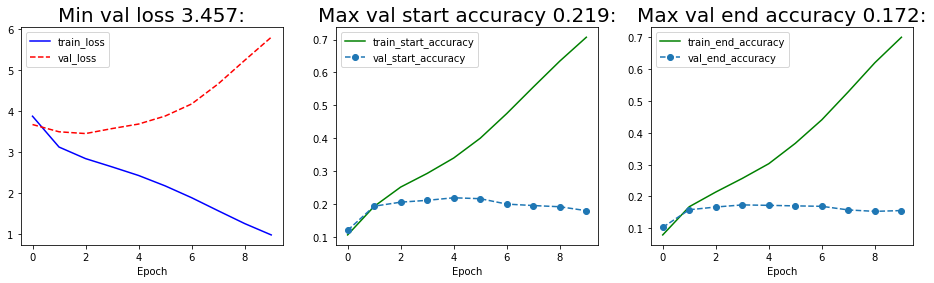

In [53]:
# training result
plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
plt.plot(train_loss, 'b-', label='train_loss')
plt.plot(val_loss, 'r--', label='val_loss')
plt.title("Min val loss {:.3f}:".format(min(val_loss)), fontsize=20 )
plt.xlabel('Epoch')
plt.legend()

max_acc = val_start_accuracy.index(max(val_start_accuracy))
plt.subplot(1, 3, 2)
plt.plot(train_start_accuracy, 'g-', label='train_start_accuracy')
plt.plot(val_start_accuracy, 'o--', label='val_start_accuracy')
plt.title("Max val start accuracy {:.3f}:".format(val_start_accuracy[max_acc]), fontsize=20 )
plt.xlabel('Epoch')
plt.legend()


plt.subplot(1, 3, 3)
plt.plot(train_end_accuracy, 'g-', label='train_end_accuracy')
plt.plot(val_end_accuracy, 'o--', label='val_end_accuracy')
plt.title("Max val end accuracy {:.3f}:".format(val_end_accuracy[max_acc]), fontsize=20 )
plt.xlabel('Epoch')
plt.legend()


plt.show()

val의 end accuracy를 보면 조금 이지만 accuracy가 향상되고 있는것을 확인할 수 있습니다.  
pretain 모델이다 보니 train accuracy가 더 빠르게 향상되는게 그래프에 보이네요.  
loss 값도 train loss는 안정적으로 0에 가깝게 수렴하고 있습니다. 


#### Pretrained model 사용하지 않은 결과

In [48]:
model = BERT4KorQuAD(config)

In [49]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

# pretrained model을 사용하지 않으니 learning_rate를 기존의 값으로 사용한다.
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4, )  # 기존 5e-4
 
best_acc = .0
patience = 0
train_start_accuracy, train_end_accuracy, train_loss =[], [], []
val_start_accuracy, val_end_accuracy, val_loss = [], [], []

for epoch in range(20):
    train_start_loss , train_end_loss, train_start_acc, train_end_acc  = train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    val_start_loss, val_end_loss, val_start_acc, val_end_acc = eval_epoch(model, dev_dataset, loss_fn, acc_fn)
    print(f'eval {epoch} >> loss: {val_start_loss:0.4f}, {val_end_loss:0.4f}, acc: {val_start_acc:0.4f}, {val_end_acc:0.4f}')
    
    train_start_accuracy.append(train_start_acc )
    train_end_accuracy.append(train_end_acc)
    train_loss.append( (train_start_loss + train_end_loss)/2 )
    
    val_start_accuracy.append( val_start_acc  )
    val_end_accuracy.append( val_end_acc )
    val_loss.append( (val_start_loss + val_end_loss)/2 )

    if best_acc < val_start_acc+val_end_acc:
        patience = 0
        best_acc = val_start_acc+val_end_acc
        model.save_weights(os.path.join(data_dir, "korquad_bert_pretrain.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 5 <= patience:
        print(f'early stopping')
        break

|          | 0/? [00:00<?, ?it/s]

eval 0 >> loss: 3.6493, 4.2430, acc: 0.1317, 0.1022
save best model


|          | 0/? [00:00<?, ?it/s]

eval 1 >> loss: 3.5605, 4.0683, acc: 0.1534, 0.1394
save best model


|          | 0/? [00:00<?, ?it/s]

eval 2 >> loss: 3.7047, 4.2173, acc: 0.1538, 0.1397
save best model


|          | 0/? [00:00<?, ?it/s]

eval 3 >> loss: 4.0243, 4.4705, acc: 0.1559, 0.1520
save best model


|          | 0/? [00:00<?, ?it/s]

eval 4 >> loss: 4.1393, 4.4828, acc: 0.1515, 0.1404


|          | 0/? [00:00<?, ?it/s]

eval 5 >> loss: 4.3458, 4.8215, acc: 0.1499, 0.1364


|          | 0/? [00:00<?, ?it/s]

eval 6 >> loss: 4.8855, 5.2548, acc: 0.1452, 0.1345


|          | 0/? [00:00<?, ?it/s]

eval 7 >> loss: 5.4874, 5.7619, acc: 0.1368, 0.1317


|          | 0/? [00:00<?, ?it/s]

eval 8 >> loss: 5.8707, 6.1277, acc: 0.1422, 0.1297
early stopping


In [50]:
dev_json = os.path.join(data_dir, "korquad_dev.json")

with open(dev_json) as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        question = vocab.decode_pieces(data['question'])
        context = vocab.decode_pieces(data['context'])
        answer = data['answer']
        answer_predict = do_predict(model, question, context)
        if answer in answer_predict:
            print(i)
            print("질문 : ", question)
            print("지문 : ", context)
            print("정답 : ", answer)
            print("예측 : ", answer_predict, "\n")

        if 100 < i:
            break
            

0
질문 :  임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
정답 :  1989년 2월 15일
예측 :  1989년 2월 15일 

2
질문 :  임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배된 연도는?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내

41
질문 :  노아의 방주에 대해 기록하고있는 복음서는 무엇인가?
지문 :  노아는 하나님의 명령에 따라 배를 만들고 가족과 정결한 짐승 암수 일곱 마리씩, 부정한 짐승 암수 한 마리씩(혹은 두 마리씩; 사본에 따라 다름), 그리고 새 암수 일곱 마리씩을 싣고 밀어닥친 홍수를 피하였다. 모든 사람들이 타락한 생활에 빠져 있어 하나님이 홍수로 심판하려 할 때 홀로 바르게 살던 노아는 하나님의 특별한 계시로 홍수가 올 것을 미리 알게 된다. 그는 길이 300 규빗, 너비 50 규빗, 높이 30 규빗(고대의 1규빗은 팔꿈치에서 가운데 손가락끝까지의 길이로 약 45~46cm를 가리킴), 상 ·중 ·하 3층으로 된 방주를 만들어 8명의 가족과, 한 쌍씩의 여러 동물을 데리고 이 방주에 탄다. 대홍수를 만나 모든 생물(물고기 제외)이 전멸하고 말았지만, 이 방주에 탔던 노아의 가족과 동물들은 살아 남았다고 한다.〈창세기〉 6장 14~16절에 보면 길이 300규빗 (약 135m), 폭 50 규빗 (약 22.5m), 높이 30 규빗 (약 13.5m)인 이 배는 지붕과 문을 달고 배 안은 3층으로 만들어져 있었다. 선체(船體)는 고페르나무(잣나무)로 되고 안쪽에는 역청(아스팔트와 비슷한 성분)을 칠하여 굳혔다고 기록하고 있다.
정답 :  창세기
예측 :  규빗, 높이 30 규빗(고대의 1규빗은 팔꿈치에서 가운데 손가락끝까지의 길이로 약 45~46cm를 가리킴), 상 ·중 ·하 3층으로 된 방주를 만들어 8명의 가족과, 한 쌍씩의 여러 동물을 데리고 이 방주에 탄다. 대홍수를 만나 모든 생물(물고기 제외)이 전멸하고 말았지만, 이 방주에 탔던 노아의 가족과 동물들은 살아 남았다고 한다.〈창세기〉 6장 14~16절에 보면 길이 300규빗 (약 135m), 폭 50 규빗 (약 22.5m), 높이 30 규빗 (약 13.5m)인 이 배는 지붕과 문을 달고 배 안은 3층으로 만들어져 있었다. 선체(船體)는 고페르나무(잣나무)로 되고 안쪽에는 역청(아스 

44
질문 :  노아의 방주는

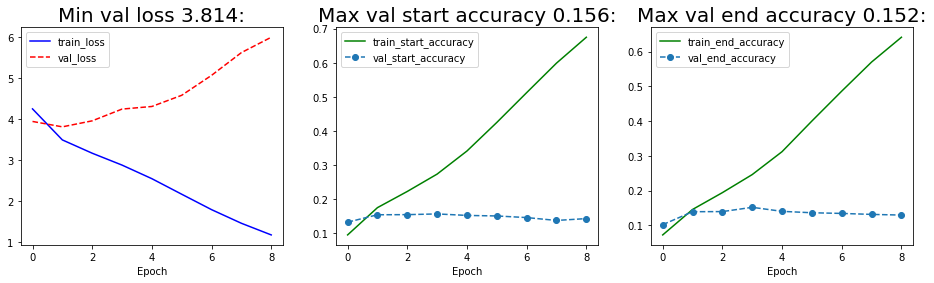

In [54]:
# training result
plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
plt.plot(train_loss, 'b-', label='train_loss')
plt.plot(val_loss, 'r--', label='val_loss')
plt.title("Min val loss {:.3f}:".format(min(val_loss)), fontsize=20 )
plt.xlabel('Epoch')
plt.legend()

max_acc = val_start_accuracy.index(max(val_start_accuracy))
plt.subplot(1, 3, 2)
plt.plot(train_start_accuracy, 'g-', label='train_start_accuracy')
plt.plot(val_start_accuracy, 'o--', label='val_start_accuracy')
plt.title("Max val start accuracy {:.3f}:".format(val_start_accuracy[max_acc]), fontsize=20 )
plt.xlabel('Epoch')
plt.legend()


plt.subplot(1, 3, 3)
plt.plot(train_end_accuracy, 'g-', label='train_end_accuracy')
plt.plot(val_end_accuracy, 'o--', label='val_end_accuracy')
plt.title("Max val end accuracy {:.3f}:".format(val_end_accuracy[max_acc]), fontsize=20 )
plt.xlabel('Epoch')
plt.legend()


plt.show()

---

2개의 퀴즈 풀이 결과를 봤을때 pretained model의 결과가 더 좋은 accuracy와 더 낮은 loss 값을 가지고 있습니다.  
그리고 퀴즈 결과를 봤을때도 pretained model의 경우가 더 짧으면서도 정답이 포함된 경우가 더 많이 보이고 있습니다.  

종헙적으로 봤을때 pretained model을 사용한 모델이 사용하지 않은 모델보다 더 좋은 결과와 학습 상태를 보이고 있습니다.

## 회고


- pretained model을 사용할때 오히려 pretained model을 사용하지 않은 모델이 더 학습이 잘되가지고 처음엔 당황을 했습니다. 그래서 시각화를 해서 어떤 점이 문제인지 살펴 봤는데 train 학습이 빠르게 진행되어서 생기는 문제인 것을 알게 되었습니다.  
따라서, 그 문제를 해결하고 Dropout 값을 증가시키고 d_model과 n_seq의 값을 감소 시켰습니다.  이미 충분한 학습이 이루어졌기에 과도하게 진행되지 않기 위해 값을 감소 시켰고 epslion 값을 줄여 좀 더 가중치가 더 들어가게 해서 gradient의 세기가 약해지는것을 방지했습니다.  
마지막으로, Learning rate의 값을 1/5 수준으로 낮춰서 과도한 학습이 되지 않도록 parameter를 조정했습니다.   
train이 빠르게 학습이 되는 속도를 늦추지는 못했지만, pretained를 사용하지 않은 model보다 사용한 model의 결과가 전체적으로 상향된 양상을 보였습니다.  
<br>
<br>


- 이전에 했던 NLP 모델인 Attention 그 다음에 한 Transformer 마지막으로 지금 BERT에 이르기까지 NLP 발전 과정에 따라 프로젝트를 진행하면서 Attention에 대한 이해가 얼마나 중요한지 알게 된것 같습니다.  
Attention에서 했던 기초 이론을 Transformer에서 나오고 다시 Transformer에서 했던 이론을 BERT에서 했기에 기초가 얼마나 중요한지 알게된 것 같습니다.  BERT 프로젝트를 진행하면서 이전에 했던 것들을 다시 돌아보니 BERT의 흐름이 좀 더 이해가 잘 된것 같습니다. 

<br>

- 개인적으로 NLP가 이론이 어렵고 복잡하다고 생각했는데 이 부분은 BERT를 하면서 특히 더 생각이 많이 났었네요.     
그렇지만 주어진 문장에서 유의미한 정보를 추출하는 NLP 특유의 느낌과 바탕이 되는 이론 그리고 그에 따른 결과물을 보는게 너무 좋고 재밌는 분야라고 느껴집니다.